# Intel PyTorch AMX BF16 Training
This code sample will quantize a ResNet50 model while using Intel's Extension for PyTorch (IPEX). The model will run inference with FP32 and INT8 precision, including static INT8 quantization and dynamic INT8 quantization. During Static Quantization, the model calibrated with the CIFAR10 dataset. The inference time will be compared, showcasing the speedup of INT8 Quantization.

## Environment Setup
Ensure the PyTorch kernel is activated before running this notebook.

## Imports, Dataset, Hyperparameters

In [1]:
import torch
import torchvision
from time import time
import os
import matplotlib.pyplot as plt
import intel_extension_for_pytorch as ipex
from intel_extension_for_pytorch.quantization import prepare, convert


In [2]:
# Hyperparameters and constants
LR = 0.001
DOWNLOAD = True
DATA = 'datasets/cifar10/'
WARMUP = 3
ITERS = 100
transform = torchvision.transforms.Compose([
torchvision.transforms.Resize((224, 224)),
torchvision.transforms.ToTensor(),
torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_dataset = torchvision.datasets.CIFAR10(
        root=DATA,
        train=False,
        transform=transform,
        download=DOWNLOAD,
)
calibration_data_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=128
)

Files already downloaded and verified


## Get model from torchvision

In [3]:
data = torch.rand(1, 3, 224, 224)
model_fp32 = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model_fp32.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Inference with FP32 model

The function below will test the inference time with input model and return the average inference time for 1 iteration.

In [4]:
def inference(model, WARMUP, ITERS, data):
    print("Warmup before benchmark ...")
    for i in range(WARMUP):
        out = model(data)

    print("Inference ...")
    inference_time = 0
    for i in range(ITERS):
        start_time = time()
        out = model(data)
        end_time = time()
        inference_time = inference_time + (end_time - start_time)

    inference_time = inference_time / ITERS
    print("Inference Time Avg: ", inference_time)
    return inference_time

## Static Quantization 
The function below staticQuantize will calibrate the fp32 model with calibration dataloader and return the quantized static int8 model.

In [5]:
def staticQuantize(model_fp32, data, calibration_data_loader):
    # Acquire inference times for static quantization INT8 model 
    qconfig_static = ipex.quantization.default_static_qconfig
    # # Alternatively, define your own qconfig:
    # from torch.ao.quantization import MinMaxObserver, PerChannelMinMaxObserver, QConfig
    # qconfig = QConfig(activation=MinMaxObserver.with_args(qscheme=torch.per_tensor_affine, dtype=torch.quint8),
    #        weight=PerChannelMinMaxObserver.with_args(dtype=torch.qint8, qscheme=torch.per_channel_symmetric))
    prepared_model_static = prepare(model_fp32, qconfig_static, example_inputs=data, inplace=False)
    print("Calibration with Static Quantization ...")
    for batch_idx, (data, target) in enumerate(calibration_data_loader):
        prepared_model_static(data)
        if batch_idx % 10 == 0:
            print("Batch %d/%d complete, continue ..." %(batch_idx+1, len(calibration_data_loader)))
    print("Calibration Done")

    converted_model_static = convert(prepared_model_static)
    with torch.no_grad():
        traced_model_static = torch.jit.trace(converted_model_static, data)
        traced_model_static = torch.jit.freeze(traced_model_static)

    # save the quantized static model 
    traced_model_static.save("quantized_model_static.pt")
    return traced_model_static


## Dynamic Quantization 
The function below dynamicQuantize will quantize the fp32 model with dynamic quantization and return the quantized dynamic int8 model.

In [9]:
def dynamicQuantize(model_fp32, data):
    # Acquire inference times for dynamic quantization INT8 model
    qconfig_dynamic = ipex.quantization.default_dynamic_qconfig
    print("Quantize Model with Dynamic Quantization ...")

    prepared_model_dynamic = prepare(model_fp32, qconfig_dynamic, example_inputs=data, inplace=False)

    converted_model_dynamic = convert(prepared_model_dynamic)
    with torch.no_grad():
        traced_model_dynamic = torch.jit.trace(converted_model_dynamic, data)
        traced_model_dynamic = torch.jit.freeze(traced_model_dynamic)

    # save the quantized dynamic model 
    traced_model_dynamic.save("quantized_model_dynamic.pt")
    return traced_model_dynamic


## Quantize the FP32 Model

In [10]:
if not os.path.exists('quantized_model_static.pt'):
    # Static Quantizaton & Save Model to quantized_model_static.pt
    print('quantize the model with static quantization')
    staticQuantize(model_fp32, data, calibration_data_loader)

In [11]:
if not os.path.exists('quantized_model_dynamic.pt'):
    # Dynamic Quantization & Save Model to quantized_model_dynamic.pt
    print('quantize the model with dynamic quantization')
    dynamicQuantize(model_fp32, data)

## Inference With FP32 Model, Static INT8 Model and Dynamic INT8 Model

In [12]:
print("Inference with FP32")
fp32_inference_time = inference(model_fp32, WARMUP, ITERS, data)

Inference with FP32
Warmup before benchmark ...
Inference ...
Inference Time Avg:  0.029211766719818115


In [13]:
print("Inference with Static INT8")
traced_model_static = torch.jit.load('quantized_model_static.pt')
traced_model_static.eval()
traced_model_static = torch.jit.freeze(traced_model_static)
int8_inference_time_static = inference(traced_model_static, WARMUP, ITERS, data)

Inference with Static INT8
Warmup before benchmark ...
Inference ...
Inference Time Avg:  0.0024858975410461427


In [14]:
print("Inference with Dynamic INT8")
traced_model_dynamic = torch.jit.load('quantized_model_dynamic.pt')
traced_model_dynamic.eval()
traced_model_dynamic = torch.jit.freeze(traced_model_dynamic)
int8_inference_time_dynamic = inference(traced_model_dynamic, WARMUP, ITERS, data)

Inference with Dynamic INT8
Warmup before benchmark ...
Inference ...
Inference Time Avg:  0.012564747333526612


## Summary of Results

Summary
FP32 inference time: 0.029
INT8 static quantization inference time: 0.002
INT8 dynamic quantization inference time: 0.013
Staic INT8 11.75X faster than FP32
Dynamic INT8 2.32X faster than FP32


<BarContainer object of 3 artists>

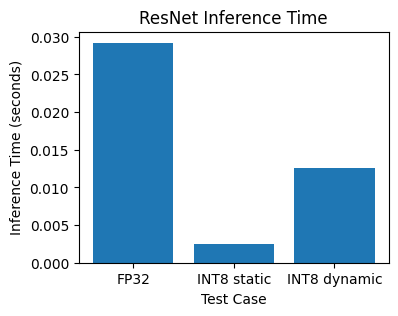

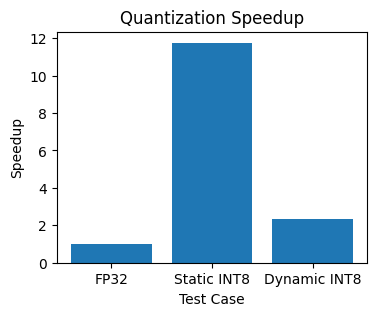

In [15]:
# Inference time results
print("Summary")
print("FP32 inference time: %.3f" %fp32_inference_time)
print("INT8 static quantization inference time: %.3f" %int8_inference_time_static)
print("INT8 dynamic quantization inference time: %.3f" %int8_inference_time_dynamic)

# Create bar chart with training time results
plt.figure(figsize=(4,3))
plt.title("ResNet Inference Time")
plt.xlabel("Test Case")
plt.ylabel("Inference Time (seconds)")
plt.bar(["FP32", "INT8 static", "INT8 dynamic"], [fp32_inference_time, int8_inference_time_static, int8_inference_time_dynamic])

# Calculate speedup when using quantization
speedup_from_fp32_static = fp32_inference_time / int8_inference_time_static
print("Staic INT8 %.2fX faster than FP32" %speedup_from_fp32_static)
speedup_from_fp32_dynamic = fp32_inference_time / int8_inference_time_dynamic
print("Dynamic INT8 %.2fX faster than FP32" %speedup_from_fp32_dynamic)


# Create bar chart with speedup results
plt.figure(figsize=(4,3))
plt.title("Quantization Speedup")
plt.xlabel("Test Case")
plt.ylabel("Speedup")
plt.bar(["FP32","Static INT8", "Dynamic INT8"], [1, speedup_from_fp32_static, speedup_from_fp32_dynamic])

In [13]:
print('[CODE_SAMPLE_COMPLETED_SUCCESFULLY]')

[CODE_SAMPLE_COMPLETED_SUCCESFULLY]
